In [2]:
import datetime as dt
import numpy as np
import xarray as xr

import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
import cartopy.crs as ccrs
import scipy as sp
import subprocess
from joblib import Parallel, delayed
import dask.array as da
from scipy.stats import spearmanr
import seaborn as sns
import regionmask
import warnings
import cartopy.feature as cfeature
warnings.filterwarnings("ignore")
import matplotlib.colors as mcolors

In [3]:
#make a download directory
import os
if not os.path.exists('download'):
    os.makedirs('download')
if not os.path.exists('figures/rpss'):
    os.makedirs('figures/rpss')
if not os.path.exists('data'):
    os.makedirs('data')

In [15]:
download = False

## Load Data

In [16]:
cfsv2_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.HINDCAST/.PENTAD_SAMPLES_FULL/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cfsv2_path = 'download/cfsv2_precip.nc'

gfdlspear_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-SPEAR/.HINDCAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
gfdlspear_path = 'download/gfdlspear_precip.nc'

cansipsic4_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.CanSIPS-IC4/.HINDCAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cansipsic4_path = 'download/cansipsic4_precip.nc'

cesm1_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CESM1/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cesm1_path = 'download/cesm1_precip.nc'

colaccsm4_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
colaccsm4_path = 'download/colaccsm4_precip.nc'

nasageos1_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.HINDCAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
nasageos1_path = 'download/nasageos1_precip.nc'
nasageos2_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
nasageos2_path = 'download/nasageos2_precip.nc'

if download:
    print(cfsv2_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cfsv2_url, '-o', cfsv2_path])
    print(gfdlspear_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', gfdlspear_url, '-o', gfdlspear_path])
    print(cesm1_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cesm1_url, '-o', cesm1_path])
    print(colaccsm4_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', colaccsm4_url, '-o', colaccsm4_path])
    print(nasageos1_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', nasageos1_url, '-o', nasageos1_path])
    print(nasageos2_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', nasageos2_url, '-o', nasageos2_path])
    #print(cansipsic4_url)
    #subprocess.call(['curl', '-b', 'cookies.txt', '-k', cansipsic4_url, '-o', cansipsic4_path])
    

In [17]:
cfsv2 = xr.open_dataset(cfsv2_path, decode_times=True)
gfdlspear = xr.open_dataset(gfdlspear_path, decode_times=True)
cesm1 = xr.open_dataset(cesm1_path, decode_times=True)
colaccsm4 = xr.open_dataset(colaccsm4_path, decode_times=True)
nasageos = xr.open_dataset(nasageos1_path, decode_times=True)
nasageos2 = xr.open_dataset(nasageos2_path, decode_times=True).isel(M=slice(0, 4))
#concatenate the two nasageos datasets
nasageos = xr.concat([nasageos, nasageos2], dim='S')
#cansipsic4 = xr.open_dataset(cansipsic4_path, decode_times=True)

In [18]:
cmap_url = "https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cmap_path = 'download/cmap_precip.nc'

print(cmap_url)
subprocess.call(['curl', '-b', 'cookies.txt', '-k', cmap_url, '-o', cmap_path])

cmap = xr.open_dataset(cmap_path, decode_times=True)
#change datetime to 01-MM-YYYY
new_dates = pd.to_datetime(cmap['T'].values, format="%d-%m-%Y").strftime("01-%m-%Y")
cmap['T'] = pd.to_datetime(new_dates, format="%d-%m-%Y")
obs = cmap['prcp_est']

obs_3m = obs + obs.shift(T=1) + obs.shift(T=2)
obs_3m = obs_3m.dropna('T')


https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc


In [19]:
spi_obs = xr.load_dataset('../data/spi3_cmap_1x1.nc')
#rename variable __xarray_dataarray_variable__ to spi
spi_obs = spi_obs.rename({'__xarray_dataarray_variable__':'spi'}).spi.sortby('T')

In [20]:
n_lead = 6

In [21]:
nmme_dict =  {'cfsv2': cfsv2, 'gfdlspear': gfdlspear, 'cesm1': cesm1, 'colaccsm4': colaccsm4, 'nasageos': nasageos}

precip_fcast_dict = {'cfsv2': None, 'gfdlspear': None, 'cesm1': None, 'colaccsm4': None, 'nasageos': None}
spi_fcast_dict = {'cfsv2': None, 'gfdlspear': None, 'cesm1': None, 'colaccsm4': None, 'nasageos': None}

In [22]:
# First, concatenate all members from all NMME models
print("Concatenating all NMME members...")
all_nmme_data = []
all_member_names = []

for (nmme_name, nmme) in nmme_dict.items():
    print(f"Adding members from {nmme_name}")
    # Add model name to member names for identification
    members = nmme['M'].values
    for member in members:
        member_id = f"{nmme_name}_{member}"
        all_member_names.append(member_id)
        all_nmme_data.append(nmme.sel(M=member))

# Concatenate all members across models
print(f"Total members across all models: {len(all_member_names)}")
combined_nmme = xr.concat(all_nmme_data, dim='M')
combined_nmme = combined_nmme.assign_coords(M=all_member_names)

total_members = len(all_member_names)


Concatenating all NMME members...
Adding members from cfsv2
Adding members from gfdlspear
Adding members from cesm1
Adding members from colaccsm4
Adding members from nasageos
Total members across all models: 67


## Precip Hindcast

In [ ]:
combined_nmme = combined_nmme.sel(S = slice('1991-01-01','2020-12-31'))
P_bar = combined_nmme['prec']  # Mean across all members
fcast_starts = P_bar['S'].values

# Initialize storage for all members
x_range = P_bar['X'].values
y_range = P_bar['Y'].values
n_lead = 6
total_members = len(all_member_names)

P_storage = np.full((total_members, len(fcast_starts), n_lead, len(y_range), len(x_range)), np.nan)

for m, member_id in enumerate(all_member_names):
    print(f"Processing member {member_id} ({m+1}/{total_members})")
    P_bar_member = combined_nmme.sel(M=member_id)['prec']


    # Process each forecast start
    for s in range(len(fcast_starts)):
        print(f"Computing Precip hindcast starting {fcast_starts[s]}")
        fcast_start = fcast_starts[s].astype('datetime64[s]').item()
        month = fcast_start.month

        # Compute climatology and anomalies
        P_bar_month = P_bar_member.sel(S=P_bar['S.month'] == month)
        P_c = P_bar_month.where(P_bar_month['S'] != fcast_starts[s]).mean(dim='S')
        P_a = P_bar_member - P_c

        ty_1 = fcast_start - relativedelta(years=1)
        ty_30 = fcast_start - relativedelta(years=30)

        obs_month = obs.sel(T=obs['T.month'] == month)
        obs_climo = obs_month.sel(T=slice(ty_30, ty_1)).mean(dim='T')
        P_fcst = P_a + obs_climo
        P_fcst_s = P_fcst.sel(S=fcast_start)
        # Create a new xarray with T as a dimension
        L_values = np.array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5,6.5,7.5])[0:n_lead]
        T_values = [fcast_start + pd.DateOffset(months=int(L - 0.5)) for L in L_values]
        P_fcst = xr.concat(
            [P_fcst_s.sel(L=L).expand_dims(T=[T]) for L, T in zip(L_values, T_values)],
            dim="T"
        ).drop_vars('L')

        P_obs = obs.sel(T=slice(ty_30, fcast_start - relativedelta(months=1)))
        blend_series = xr.concat([P_obs, P_fcst], dim='T').sortby('T')
        blend_series_season = blend_series + blend_series.shift(T=1) + blend_series.shift(T=2)
        blend_series_season = blend_series_season.dropna('T').sortby('T')
        for l in range(n_lead):
            P_storage[m, s, l, :, :] = blend_series_season.isel(T=-n_lead+l).values


P_s = xr.DataArray(
        P_storage,
        dims=['M', 'S', 'L', 'Y', 'X'],
        coords={'M': all_member_names, 'S': fcast_starts, 'L': L_values, 'Y': y_range, 'X': x_range},
        name='precip')



Processing member cfsv2_1.0 (1/67)
Computing Precip hindcast starting 1991-01-01T00:00:00.000000000
Computing Precip hindcast starting 1991-02-01T00:00:00.000000000
Computing Precip hindcast starting 1991-03-01T00:00:00.000000000
Computing Precip hindcast starting 1991-04-01T00:00:00.000000000
Computing Precip hindcast starting 1991-05-01T00:00:00.000000000
Computing Precip hindcast starting 1991-06-01T00:00:00.000000000
Computing Precip hindcast starting 1991-07-01T00:00:00.000000000
Computing Precip hindcast starting 1991-08-01T00:00:00.000000000
Computing Precip hindcast starting 1991-09-01T00:00:00.000000000
Computing Precip hindcast starting 1991-10-01T00:00:00.000000000
Computing Precip hindcast starting 1991-11-01T00:00:00.000000000
Computing Precip hindcast starting 1991-12-01T00:00:00.000000000
Computing Precip hindcast starting 1992-01-01T00:00:00.000000000
Computing Precip hindcast starting 1992-02-01T00:00:00.000000000
Computing Precip hindcast starting 1992-03-01T00:00:00.

In [29]:

    # Save the results
P_s.to_netcdf(f'data/precip_hcast_all_members.nc')

P_fcst = P_s

# Spi Hindcast

In [25]:
def compute_spi_single_grid(yy, xx, precip):
    precip_grid = precip.sel(X=x_range[xx], Y=y_range[yy])
    precip_grid = precip_grid.values
    #t = s + pd.DateOffset(months=int(l))
    #t_month = t.month

    if np.all(np.isnan(precip_grid)):  # Skip if all values are NaN
        return np.nan

    # Fit Pearson Type III distribution
    try:
        a, loc, scale = sp.stats.pearson3.fit(precip_grid)
        cdf_values = sp.stats.pearson3.cdf(precip_grid, skew=a, loc=loc, scale=scale)

        # Handle zero-inflated data
        q = np.sum(precip_grid == 0) / len(precip_grid)
        cdf_values = (cdf_values * (1 - q)) + q

        # Ensure CDF is within valid bounds
        cdf_values = np.clip(cdf_values, 1e-6, 1 - 1e-6)

        # Convert CDF to SPI
        spi_time_series = sp.stats.norm.ppf(cdf_values)
        return spi_time_series
    except Exception as e:
        print(f"Error fitting distribution at (X={x_range[j]}, Y={y_range[i]}): {e}")
        return np.nan

def compute_spi(precip):
    return Parallel(n_jobs=-1)(
        delayed(compute_spi_single_grid)(yy, xx, precip)
        for yy in range(len(y_range))
        for xx in range(len(x_range))
    )



In [ ]:
for (nmme_name, p_fcast) in P_fcast.items():
    print(f"######################")
    print(f"Processing NMME: {nmme_name.upper()}")
    print(f"######################")
    # Initialize storage
    x_range = P_bar['X'].values
    y_range = P_bar['Y'].values
    fcast_starts = p_fcast['S'].values

    spi_storage_list = []

    for lead in range(n_lead):
        print(f"Computing SPI for lead time {lead + 1}")
        precip_L = p_fcast.isel(L=lead)
        spi_month_list =[]
        for month in range(1, 13):
            print(f"---- Computing SPI for month {month}")

            precip_L_month = precip_L.sel(S=precip_L['S.month'] == month)
            months = precip_L_month['S'].values

            spi = np.array(compute_spi(precip_L_month)).reshape(len(y_range), len(x_range), len(months))
            # transpose to match the xarray dimensions
            spi = np.transpose(spi, (2, 0, 1))
            spi_xr = xr.DataArray(
                spi,
                dims=['S','Y', 'X'],
                coords={'S': months, 'Y': y_range, 'X': x_range},
                name='spi'
            )
            spi_month_list.append(spi_xr)
        spi_month = xr.concat(spi_month_list, dim='S')
        spi_storage_list.append(spi_month)
    spi_storage = xr.concat(spi_storage_list, dim='L')
    #use the same L grid as precip forecast
    spi_storage['L'] = p_fcast['L']
    
    spi_fcast_dict[nmme_name] = spi_storage
    spi_storage.to_netcdf(f'data/spi_hindcast_{nmme_name}.nc')


######################
Processing NMME: CFSV2
######################
Computing SPI for lead time 1
---- Computing SPI for month 1
---- Computing SPI for month 2
---- Computing SPI for month 3
---- Computing SPI for month 4
---- Computing SPI for month 5
---- Computing SPI for month 6
---- Computing SPI for month 7
---- Computing SPI for month 8
---- Computing SPI for month 9
---- Computing SPI for month 10
---- Computing SPI for month 11
---- Computing SPI for month 12
Computing SPI for lead time 2
---- Computing SPI for month 1
---- Computing SPI for month 2
---- Computing SPI for month 3
---- Computing SPI for month 4
---- Computing SPI for month 5
---- Computing SPI for month 6
---- Computing SPI for month 7
---- Computing SPI for month 8
---- Computing SPI for month 9
---- Computing SPI for month 10
---- Computing SPI for month 11
---- Computing SPI for month 12
Computing SPI for lead time 3
---- Computing SPI for month 1
---- Computing SPI for month 2
---- Computing SPI for month 

In [30]:
# Initialize storage
x_range = P_bar['X'].values
y_range = P_bar['Y'].values
fcast_starts = P_fcst['S'].values
members = P_fcst['M'].values
n_members = len(members)

spi_storage_list = []

for lead in range(n_lead):
    print(f"Computing SPI for lead time {lead + 1}")
    
    # subset single lead, keeps M, Y, X, S
    precip_L = P_fcst.isel(L=lead)  
    
    spi_member_list = []
    for m in members:
        print(f"--- Member {m}")
        precip_L_m = precip_L.sel(M=m)  # now dims: Y, X, S

        spi_month_list = []
        for month in range(1, 13):
            print(f"------ Computing SPI for month {month}")

            precip_L_month = precip_L_m.sel(S=precip_L_m['S.month'] == month)
            months = precip_L_month['S'].values

            # compute SPI (your function must take array shape [S, Y, X] or similar)
            spi = np.array(compute_spi(precip_L_month)).reshape(
                len(y_range), len(x_range), len(months)
            )

            # transpose to match xarray (S,Y,X)
            spi = np.transpose(spi, (2, 0, 1))
            spi_xr = xr.DataArray(
                spi,
                dims=['S', 'Y', 'X'],
                coords={'S': months, 'Y': y_range, 'X': x_range},
                name='spi'
            )
            spi_month_list.append(spi_xr)
        
        spi_month = xr.concat(spi_month_list, dim='S')
        # add back member dim
        spi_month = spi_month.expand_dims(M=[m])
        spi_member_list.append(spi_month)
    
    # concat all members for this lead
    spi_members = xr.concat(spi_member_list, dim='M')
    # add lead dimension
    spi_members = spi_members.expand_dims(L=[P_fcst['L'].values[lead]])
    spi_storage_list.append(spi_members)

# concat all leads
spi_storage = xr.concat(spi_storage_list, dim='L')

# make sure coords align with P_fcst
spi_storage = spi_storage.assign_coords(L=P_fcst['L'], M=members)

spi_fcast_dict[nmme_name] = spi_storage
spi_storage.to_netcdf(f'data/spi_hindcast_all_members.nc')

Computing SPI for lead time 1
--- Member cfsv2_1.0
------ Computing SPI for month 1
------ Computing SPI for month 2
------ Computing SPI for month 3
------ Computing SPI for month 4
------ Computing SPI for month 5
------ Computing SPI for month 6
------ Computing SPI for month 7
------ Computing SPI for month 8
------ Computing SPI for month 9
------ Computing SPI for month 10
------ Computing SPI for month 11
------ Computing SPI for month 12
--- Member cfsv2_2.0
------ Computing SPI for month 1
------ Computing SPI for month 2
------ Computing SPI for month 3
------ Computing SPI for month 4
------ Computing SPI for month 5
------ Computing SPI for month 6
------ Computing SPI for month 7
------ Computing SPI for month 8
------ Computing SPI for month 9
------ Computing SPI for month 10
------ Computing SPI for month 11
------ Computing SPI for month 12
--- Member cfsv2_3.0
------ Computing SPI for month 1
------ Computing SPI for month 2
------ Computing SPI for month 3
------ Com

# Probas

In [23]:
spi_all_members = xr.load_dataset('data/spi_hindcast_all_members.nc').spi.transpose('M', 'S', 'L', 'Y', 'X')
precip_all_members = xr.load_dataset('data/precip_hcast_all_members.nc').precip.transpose('M', 'S', 'L', 'Y', 'X')

In [24]:

# Create probabilistic forecasts by counting categories
fcast_starts = spi_all_members['S'].values
y_range = spi_all_members['Y'].values
x_range = spi_all_members['X'].values
n_lead = len(spi_all_members['L'].values)
members = spi_all_members['M'].values
prob_storage = np.full((len(fcast_starts), n_lead, len(y_range), len(x_range), 3), np.nan)
L_values = spi_all_members['L'].values


In [10]:
for s in range(len(fcast_starts)):
    for l in range(n_lead):
        print(f"Computing probabilities for start {s+1}/{len(fcast_starts)}, lead {l+1}/{n_lead}")
        target_month = (pd.to_datetime(fcast_starts[s]) + pd.DateOffset(months=int(L_values[l]-0.5))).month
        # Get climatology for the target month
        spi_climo = spi_obs.sel(T=spi_obs['T.month'] == target_month)
        # Calculate 33rd and 67th percentiles
        q33 = spi_climo.quantile(0.33, dim='T')
        q67 = spi_climo.quantile(0.67, dim='T')
        
        for i in range(len(y_range)):
            for j in range(len(x_range)):
                # Get SPI values across all members for this grid point
                spi_members = spi_all_members.sel(S=fcast_starts[s], L=L_values[l], Y=y_range[i], X=x_range[j]).values
                
                # Skip if all values are NaN
                if not np.all(np.isnan(spi_members)):
                    # Remove NaN values
                    valid_spi = spi_members[~np.isnan(spi_members)]
                    
                    if len(valid_spi) > 0:
                        # Count categories
                        below_normal = np.sum(valid_spi < q33.sel(Y=y_range[i], X=x_range[j]).values)
                        near_normal = np.sum((valid_spi >= q33.sel(Y=y_range[i], X=x_range[j]).values) & (valid_spi <= q67.sel(Y=y_range[i], X=x_range[j]).values))
                        above_normal = np.sum(valid_spi > q67.sel(Y=y_range[i], X=x_range[j]).values)


                        total = len(valid_spi)
                        
                        # Store probabilities [below, near, above]
                        prob_storage[s, l, i, j, 0] = below_normal / total
                        prob_storage[s, l, i, j, 1] = near_normal / total
                        prob_storage[s, l, i, j, 2] = above_normal / total

Computing probabilities for start 1/360, lead 1/6
Computing probabilities for start 1/360, lead 2/6
Computing probabilities for start 1/360, lead 3/6
Computing probabilities for start 1/360, lead 4/6
Computing probabilities for start 1/360, lead 5/6
Computing probabilities for start 1/360, lead 6/6
Computing probabilities for start 2/360, lead 1/6
Computing probabilities for start 2/360, lead 2/6
Computing probabilities for start 2/360, lead 3/6
Computing probabilities for start 2/360, lead 4/6
Computing probabilities for start 2/360, lead 5/6
Computing probabilities for start 2/360, lead 6/6
Computing probabilities for start 3/360, lead 1/6
Computing probabilities for start 3/360, lead 2/6
Computing probabilities for start 3/360, lead 3/6
Computing probabilities for start 3/360, lead 4/6
Computing probabilities for start 3/360, lead 5/6
Computing probabilities for start 3/360, lead 6/6
Computing probabilities for start 4/360, lead 1/6
Computing probabilities for start 4/360, lead 2/6


KeyboardInterrupt: 

In [236]:
# Convert to xarray
category_names = [0, 1, 2]  # 0: below normal, 1: near normal, 2: above normal
spi_prob_forecast = xr.DataArray(
    prob_storage,
    dims=['S', 'L', 'Y', 'X', 'category'],
    coords={'S': fcast_starts, 'L': L_values, 'Y': y_range, 'X': x_range, 'category': category_names},
    name='spi'
)

# Save results
spi_prob_forecast.to_netcdf('data/spi_prob_hcast_thresholdquantile.nc')

In [25]:
# Create probabilistic forecasts by counting categories
fcast_starts = precip_all_members['S'].values
y_range = precip_all_members['Y'].values
x_range = precip_all_members['X'].values
n_lead = len(precip_all_members['L'].values)
members = precip_all_members['M'].values
prob_storage = np.full((len(fcast_starts), n_lead, len(y_range), len(x_range), 3), np.nan)
L_values = precip_all_members['L'].values

In [370]:
# for s in range(len(fcast_starts)):
#     for l in range(n_lead):
#         print(f"Computing probabilities for start {s+1}/{len(fcast_starts)}, lead {l+1}/{n_lead}")
#         target_month = (pd.to_datetime(fcast_starts[s]) + pd.DateOffset(months=int(L_values[l]-0.5))).month
#         # Get climatology for the target month
#         precip_climo = obs_3m.sel(T=slice('1991-01-01', '2020-12-31')).sel(T=obs_3m.sel(T=slice('1991-01-01', '2020-12-31'))['T.month'] == target_month)
#         # Calculate 33rd and 67th percentiles
#         q33 = precip_climo.quantile(0.33, dim='T')
#         q67 = precip_climo.quantile(0.67, dim='T')
        
#         for i in range(len(y_range)):
#             for j in range(len(x_range)):
#                 # Get SPI values across all members for this grid point
#                 precip_members = precip_all_members.sel(S=fcast_starts[s], L=L_values[l], Y=y_range[i], X=x_range[j]).values
                
#                 # Skip if all values are NaN
#                 if not np.all(np.isnan(precip_members)):
#                     # Remove NaN values
#                     valid_spi = precip_members[~np.isnan(precip_members)]
                    
#                     if len(valid_spi) > 0:
#                         # Count categories
#                         below_normal = np.sum(valid_spi < q33.sel(Y=y_range[i], X=x_range[j]).values)
#                         near_normal = np.sum((valid_spi >= q33.sel(Y=y_range[i], X=x_range[j]).values) & (valid_spi <= q67.sel(Y=y_range[i], X=x_range[j]).values))
#                         above_normal = np.sum(valid_spi > q67.sel(Y=y_range[i], X=x_range[j]).values)


#                         total = len(valid_spi)
                        
#                         # Store probabilities [below, near, above]
#                         prob_storage[s, l, i, j, 0] = below_normal / total
#                         prob_storage[s, l, i, j, 1] = near_normal / total
#                         prob_storage[s, l, i, j, 2] = above_normal / total

In [26]:
n_lead = 6
for s in range(len(fcast_starts)):
    for l in range(n_lead):
        print(f"Computing probabilities for start {s+1}/{len(fcast_starts)}, lead {l+1}/{n_lead}")

        target_month = (pd.to_datetime(fcast_starts[s]) + pd.DateOffset(months=int(L_values[l]-0.5))).month

        # Climatology (1991–2020, same month)
        precip_climo = (
            obs_3m.sel(T=slice('1991-01-01', '2020-12-31'))
                  .sel(T=obs_3m.sel(T=slice('1991-01-01', '2020-12-31'))['T.month'] == target_month)
        )

        # Thresholds: dims (Y, X)
        q33 = precip_climo.quantile(0.33, dim="T").drop_vars("quantile", errors="ignore")
        q67 = precip_climo.quantile(0.67, dim="T").drop_vars("quantile", errors="ignore")


        # Forecast ensemble: dims (M, Y, X)
        precip_members = precip_all_members.sel(S=fcast_starts[s], L=L_values[l])

        valid_mask = ~np.isnan(precip_members)

        # Broadcast thresholds to ensemble members
        q33_b = q33.broadcast_like(precip_members)
        q67_b = q67.broadcast_like(precip_members)

        # Category counts
        below = ((precip_members < q33_b) & valid_mask).sum(dim="M")
        near  = ((precip_members >= q33_b) & (precip_members <= q67_b) & valid_mask).sum(dim="M")
        above = ((precip_members > q67_b) & valid_mask).sum(dim="M")

        total = valid_mask.sum(dim="M")


        # Probabilities: dims (Cat, Y, X)
        probs = xr.concat(
            [below, near, above],
            dim=pd.Index([0, 1, 2 ], name="category")
        ) / total

        # Store in ndarray
        prob_storage[s, l, :, :, :] = probs.transpose("Y", "X", "category").values


Computing probabilities for start 1/360, lead 1/6
Computing probabilities for start 1/360, lead 2/6
Computing probabilities for start 1/360, lead 3/6
Computing probabilities for start 1/360, lead 4/6
Computing probabilities for start 1/360, lead 5/6
Computing probabilities for start 1/360, lead 6/6
Computing probabilities for start 2/360, lead 1/6
Computing probabilities for start 2/360, lead 2/6
Computing probabilities for start 2/360, lead 3/6
Computing probabilities for start 2/360, lead 4/6
Computing probabilities for start 2/360, lead 5/6
Computing probabilities for start 2/360, lead 6/6
Computing probabilities for start 3/360, lead 1/6
Computing probabilities for start 3/360, lead 2/6
Computing probabilities for start 3/360, lead 3/6
Computing probabilities for start 3/360, lead 4/6
Computing probabilities for start 3/360, lead 5/6
Computing probabilities for start 3/360, lead 6/6
Computing probabilities for start 4/360, lead 1/6
Computing probabilities for start 4/360, lead 2/6


In [27]:
# Convert to xarray
category_names = [0, 1, 2]  # 0: below normal, 1: near normal, 2: above normal
precip_prob_forecast = xr.DataArray(
    prob_storage,
    dims=['S', 'L', 'Y', 'X', 'category'],
    coords={'S': fcast_starts, 'L': L_values, 'Y': y_range, 'X': x_range, 'category': category_names},
    name='precip'
)

# Save results
precip_prob_forecast.to_netcdf('data/precip_prob_hcast_thresholdquantile.nc')



In [70]:
# Assume precip_all_members dims = ('S','L','member','Y','X')
ens_dim = 'M'  # change if your ensemble dim is named differently



# Category masks
below = (precip_all_members < 1).mean(dim=ens_dim, skipna=True)
near  = ((precip_all_members >= 1) & (precip_all_members <= 4)).mean(dim=ens_dim, skipna=True)
above = (precip_all_members > 4).mean(dim=ens_dim, skipna=True)

# Combine into Cat dimension
prob_fixed = xr.concat([below, near, above], dim="category").assign_coords(category=[0, 1, 2])
prob_fixed = prob_fixed.transpose("S", "L", "Y", "X", "category")

# Sanity check: should sum to ~1
print("Sum check:", prob_fixed.sum("category").min().item(), prob_fixed.sum("category").max().item())

prob_fixed.to_netcdf('data/precip_prob_hcast_thresholdfixed.nc')

Sum check: 0.9999999999999999 1.0


In [ ]:
# Assume precip_all_members dims = ('S','L','member','Y','X')
ens_dim = 'M'  # change if your ensemble dim is named differently

# Category masks
below = (spi_all_members < -0.5).mean(dim=ens_dim, skipna=True)
near  = ((spi_all_members >= -0.5) & (spi_all_members <= 0.5)).mean(dim=ens_dim, skipna=True)
above = (spi_all_members > 0.5).mean(dim=ens_dim, skipna=True)

# Combine into Cat dimension
prob_fixed = xr.concat([below, near, above], dim="category").assign_coords(category=[0, 1, 2])
prob_fixed = prob_fixed.transpose("S", "L", "Y", "X", "category")

# Sanity check: should sum to ~1
print("Sum check:", prob_fixed.sum("category").min().item(), prob_fixed.sum("category").max().item())

prob_fixed.to_netcdf('data/spi_prob_hcast_thresholdfixed.nc')

# Skill

In [71]:
spi_prob_forecast = xr.load_dataset('data/spi_prob_hcast_thresholdfixed.nc').spi

In [28]:
precip_prob_forecast = xr.load_dataset('data/precip_prob_hcast_thresholdquantile.nc').precip

In [29]:
spi_obs = xr.load_dataset('../data/spi3_cmap_1x1.nc')
#rename variable __xarray_dataarray_variable__ to spi
spi_obs = spi_obs.rename({'__xarray_dataarray_variable__':'spi'}).spi.sortby('T')


In [240]:
thresh33 = -0.5
thresh67 = 0.5

# classify
spi_cat = xr.full_like(spi_obs, np.nan, dtype=int)
spi_cat = xr.where(spi_obs <= thresh33, 0, spi_cat)
spi_cat = xr.where((spi_obs > thresh33) & (spi_obs < thresh67), 1, spi_cat)
spi_cat = xr.where(spi_obs >= thresh67, 2, spi_cat)

#restire nan 
spi_cat = spi_cat.where(~np.isnan(spi_obs))

In [73]:
thresh33 = 1
thresh67 = 4

# classify
precip_cat = xr.full_like(obs_3m, np.nan, dtype=int)
precip_cat = xr.where(obs_3m <= thresh33, 0, precip_cat)
precip_cat = xr.where((obs_3m > thresh33) & (obs_3m < thresh67), 1, precip_cat)
precip_cat = xr.where(obs_3m >= thresh67, 2, precip_cat)

#restire nan 
precip_cat = precip_cat.where(~np.isnan(obs_3m))

In [254]:
# compute month-specific quantiles (per gridpoint)
q33 = spi_obs.groupby('T.month').quantile(0.33, dim='T')
q67 = spi_obs.groupby('T.month').quantile(0.67, dim='T')

# classify directly with groupby.map
def classify_month(da, q33=q33, q67=q67):
    m = int(da['T.month'][0])  # current month
    low = q33.sel(month=m)
    high = q67.sel(month=m)

    out = xr.full_like(da, np.nan, dtype=int)
    out = xr.where(da <= low, 0, out)
    out = xr.where((da > low) & (da < high), 1, out)
    out = xr.where(da >= high, 2, out)
    return out

spi_cat = spi_obs.groupby('T.month').map(classify_month)

# keep NaN where original was NaN
spi_cat = spi_cat.where(~np.isnan(spi_obs))

In [30]:
# compute month-specific quantiles (per gridpoint)
q33 = obs_3m.sel(T=slice('1991-01-01', '2020-12-31')).groupby('T.month').quantile(0.33, dim='T')
q67 = obs_3m.sel(T=slice('1991-01-01', '2020-12-31')).groupby('T.month').quantile(0.67, dim='T')

# classify directly with groupby.map
def classify_month(da, q33=q33, q67=q67):
    m = int(da['T.month'][0])  # current month
    low = q33.sel(month=m)
    high = q67.sel(month=m)

    out = xr.full_like(da, np.nan, dtype=int)
    out = xr.where(da <= low, 0, out)
    out = xr.where((da > low) & (da < high), 1, out)
    out = xr.where(da >= high, 2, out)
    return out

precip_cat = obs_3m.groupby('T.month').map(classify_month)

# keep NaN where original was NaN
precip_cat = precip_cat.where(~np.isnan(obs_3m))

In [31]:
mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask( spi_obs['X'], spi_obs['Y'])

In [32]:
import numpy as np
import xarray as xr
import pandas as pd

import numpy as np
import xskillscore as xs

def rps_score(probs, outcomes):
    N, K = probs.shape
    #create nan edge case
    if np.all(np.isnan(probs)) or np.all(np.isnan(outcomes)):
        return np.nan

    # One-hot encode outcomes
    one_hot = np.zeros((N, K))
    one_hot[np.arange(N), outcomes.astype(int)] = 1

    # Cumulative sums across categories
    cum_probs = np.cumsum(probs, axis=1)
    cum_outcomes = np.cumsum(one_hot, axis=1)

    # Squared differences
    diffs = (cum_probs - cum_outcomes) ** 2

    # Sum over categories and average over cases
    rps_vals = diffs.sum(axis=0) 
    return rps_vals.mean()


def compute_rpss(obs, fcst, ref_fcst="climatology"):
    """Compute RPSS given forecast probs and obs categories."""
    n_cat = fcst.sizes["category"]

    # Reference = climatology (uniform or from obs frequencies)
    if ref_fcst == "climatology":
        ref_probs = np.ones(n_cat) / n_cat
    else:
        raise NotImplementedError

    results = []

    for s_month in range(1, 13):  # start months
        for lead_time in range(fcst.sizes["L"]):
            # Forecasts for given start month and lead
            fcst_sel = fcst.sel(S=fcst['S.month'] == s_month).isel(L=lead_time).transpose('S', 'Y', 'X', 'category')
            t_month = (s_month + lead_time) % 12
            t_month = 12 if t_month == 0 else t_month

            # Convert S→T
            S_values = fcst_sel['S'].values
            T_values = [pd.Timestamp(s) + pd.DateOffset(months=lead_time) for s in S_values]
            fcst_sel['S'] = T_values
            fcst_month = fcst_sel.rename({'S': 'T'})

            # Matching obs
            obs_month = obs.sel(T=obs['T.month'] == t_month).sel(T=fcst_month['T']).transpose('T', 'Y', 'X')
            #give same NA
            fcst_month = fcst_month.where(obs_month.notnull(), drop=False).transpose('T', 'Y', 'X', 'category')
            fcst_month = fcst_month.where(mask==0)

            # Align
            #fcst_aligned, obs_aligned = xr.align(fcst_month, obs_month)
            # rps_vals = xr.apply_ufunc(
            #     rps_score,
            #     fcst_aligned,
            #     obs_aligned,
            #     input_core_dims=[["T", "Cat"], ["T"]],
            #     vectorize=True,
            #     dask="parallelized",
            #     output_dtypes=[float],
            # )

            # Reference RPS (climatology)
            ref_probs_da = xr.DataArray(ref_probs, dims=["category"])
            ref_probs_broadcast = ref_probs_da.broadcast_like(fcst_month)


            # ref_rps_vals = xr.apply_ufunc(
            #     rps_score,
            #     ref_probs_broadcast,
            #     obs_aligned,
            #     input_core_dims=[["T", "Cat"], ["T"]],
            #     vectorize=True,
            #     dask="parallelized",
            #     output_dtypes=[float],
            # )

            ohe_obs = xr.concat(
        [
            (obs_month == 0).assign_coords(category=0),
            (obs_month == 1).assign_coords(category=1),
            (obs_month == 2).assign_coords(category=2),
        ],
        'category').where(obs_month.notnull()).transpose('T', 'Y', 'X', 'category')



            rps_vals = xs.rps(ohe_obs, fcst_month, dim="T", category_edges=None, input_distributions="p")
            ref_rps_vals = xs.rps(ohe_obs, ref_probs_broadcast, dim="T", category_edges=None, input_distributions="p")

            # RPSS directly (no mean over T outside)
            rpss = 1 - (rps_vals / ref_rps_vals)

            results.append(
                rpss.expand_dims({"L": [lead_time], "Smonth": [s_month]})
            )

            rpss_final = xr.combine_by_coords(results)
            rpss_final = rpss_final.where(mask==0)

    return rpss_final

rpss_final = compute_rpss(precip_cat, precip_prob_forecast)



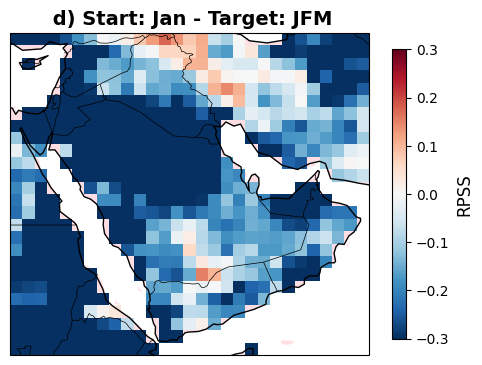

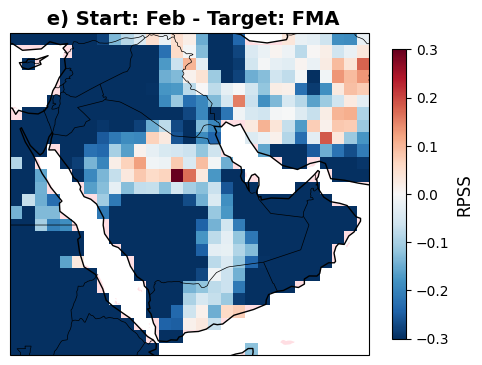

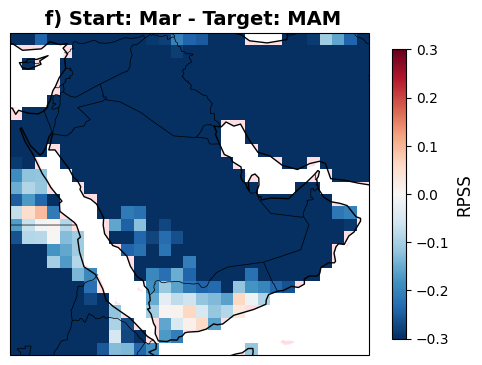

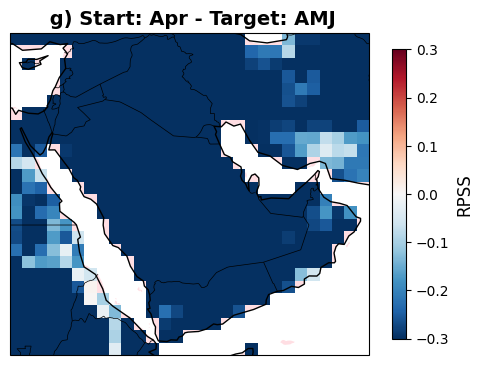

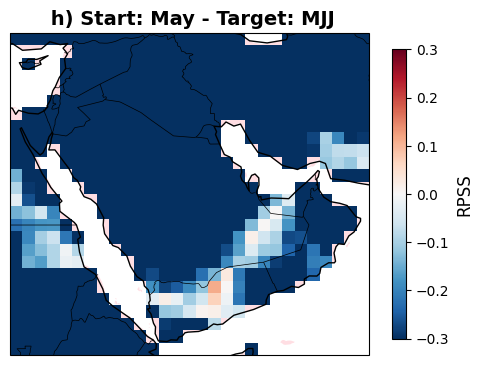

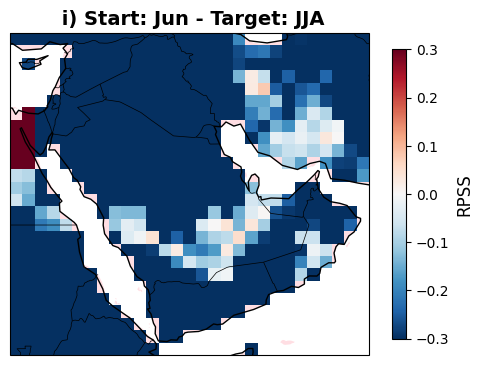

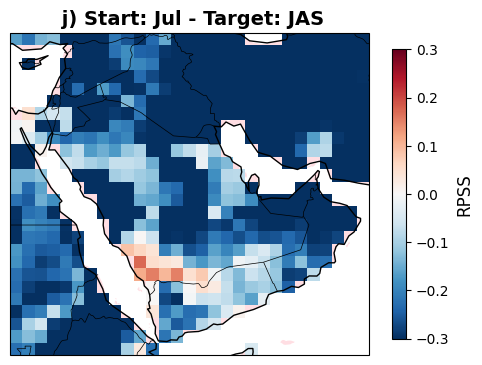

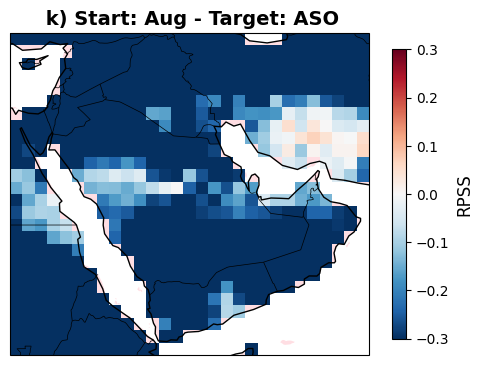

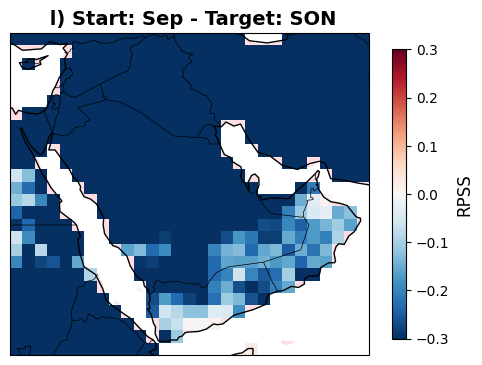

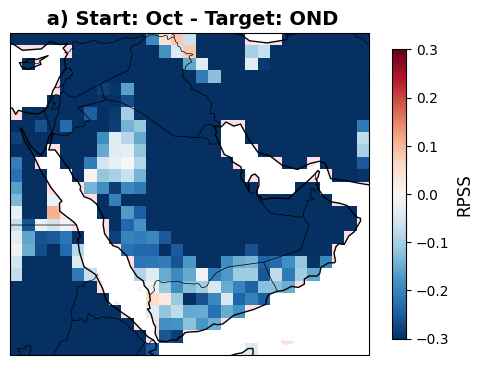

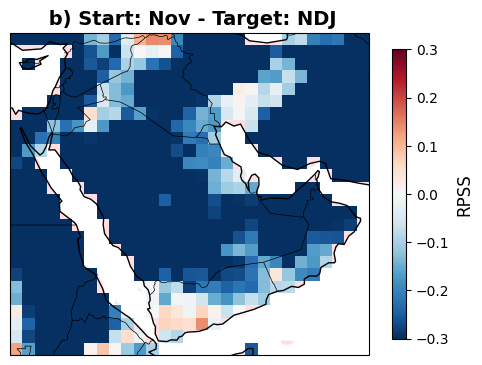

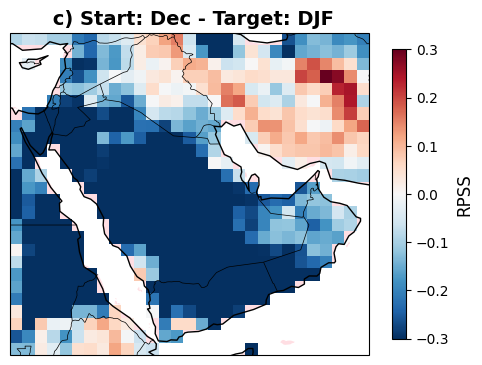

In [35]:

L = 2
for month in range(1, 13):
    seasons_to_month = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                        7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}

    start = seasons_to_month[month]
    target_num = month + L 
    if target_num > 12:
        target_num -= 12

    month_to_season = {1: "NDJ", 2: "DJF", 3: "JFM", 4: "FMA", 5: "MAM", 6: "AMJ",
                       7: "MJJ", 8: "JJA", 9: "JAS", 10: "ASO", 11: "SON", 12: "OND"}
    
    season_to_label = {"OND": "a)", "NDJ": "b)", "DJF": "c)", "JFM": "d)", "FMA": "e)", "MAM": "f)",
                       "AMJ": "g)", "MJJ": "h)", "JJA": "i)", "JAS": "j)", "ASO": "k)", "SON": "l)"}
    
    target = month_to_season[target_num]
    
    label = season_to_label[target]
    
    title_str = f" {label} Start: {start} - Target: {target}"

    rpss_final_sel = rpss_final.sel(Smonth=month, L=L)
    fig, ax = plt.subplots(
            figsize=(5, 4),
            subplot_kw={"projection": ccrs.PlateCarree()}
        )

    im = rpss_final_sel.plot(
            ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=-0.3, vmax=0.3,
            add_colorbar=False
        )

    
    # add coastlines, borders, land
    ax.coastlines(resolution="110m", linewidth=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor="lightpink", alpha=0.45)

    # titles
    plt.title(f"{title_str}", fontsize=14, fontweight='bold')

    # colorbar
    cbar = plt.colorbar(im, ax=ax, orientation="vertical", shrink=0.8)
    cbar.set_label("RPSS", fontsize=12)

    plt.tight_layout()
    plt.show()
        # save
    fig.savefig(
        f"figures//rpss/start{start}_target{target}.pdf",
        dpi=150, bbox_inches="tight"
    )

